In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import img_to_array, load_img

## 4. Train a classification convolutional neural network (CNN) with accuracy as our loss function - goal is to predict the presence of gerrymandering.

### Model Data Preparation

In [3]:
img_directory = "intermediate\maps"

In [4]:
label = pd.read_csv("input/cnn_target.csv", header=None)
label = label.rename(columns={0: "tag", 1:"eg_swing"})
label.head()

,tag,eg_swing
0,0001_1952_NY,0.03
1,0002_1952_CA,0.05
2,0003_1952_PA,0.04
3,0004_1952_IL,-0.03
4,0005_1952_TX,0.18


#### Data Augmentation

Our first goal is to augment our dataset to increase the dataset size. To do this, we will perform two types of augmentation: flipping, and rotation.

I've refrained from conducting other types of augmentation (shearing, scaling, stretching, [etc.](https://sander.ai/2015/03/17/plankton.html)) as I wanted to preserve spatial relationships between districts (especially the differences between redistricting).

Let's start with a single example - the California plot after the 2011 redistricting.

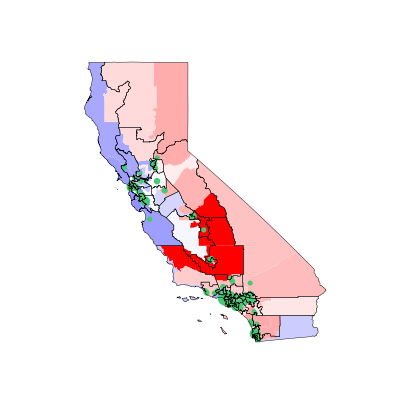

In [5]:
example_img = load_img("intermediate/maps/0306_2012_CA.png")
example_img

In [6]:
example_img_arr = img_to_array(example_img)
example_img_arr = example_img_arr.reshape((1, ) + example_img_arr.shape)

In [21]:
img_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True)

i = 0
for batch in img_gen.flow(example_img_arr, batch_size = 1, save_to_dir ='img', 
                          save_prefix ='ex_augmented_photo', save_format ='png'):
    i += 1
    if i > 3:
        break 

![Image 1](img/ex_augmented_photo_0_3523.png)
![Image 2](img/ex_augmented_photo_0_9682.png)

The example images show the augmentations work as expected.


#### Attaching Labels 

Each label represents the efficiency gap swing after redistricting - **positive scores represent gerrymandered gains for Republicans, and negative scores represent gerrymandered gains for Democrats.**

We are going to use a multiclass classification model to avoid some of the difficulties and problems with CNN architectures for regression (as mentioned [here](https://stats.stackexchange.com/questions/335836/cnn-architectures-for-regression), example by [Fischer et. al., 2015](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf)). Classification will also theoretically provide a larger acceptable margin of error. We do not really care about the specific number, moreso the presence of a party gerrymandering a district.

We will provide 3 labels:
- (R) "Gerrymander for Republicans" - swing >= 0.05
- (NC) "No Change" - -0.05 > swing < 0.05
- (D) "Gerrymander for Democrats" - -0.05 <= swing

In [5]:
buckets = [-1, -0.05, 0.05, 1]
buckets_name = ["D", "NC", "R"]

label["class"] = pd.cut(label["eg_swing"], buckets, labels=buckets_name)

In [6]:
label.head()

,tag,eg_swing,class
0,0001_1952_NY,0.03,NC
1,0002_1952_CA,0.05,NC
2,0003_1952_PA,0.04,NC
3,0004_1952_IL,-0.03,NC
4,0005_1952_TX,0.18,R


C:\Users\tobyt\AppData\Local\Temp\ipykernel_12608\605776009.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(labels=buckets_name, rotation=45)


Text(0.5, 1.0, 'Efficiency Gap Swings - Class Spread')

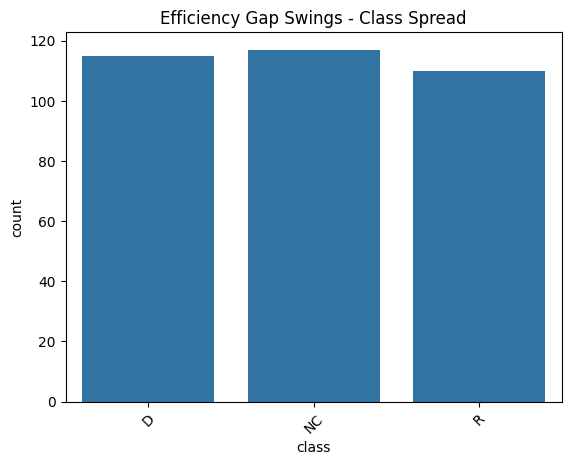

In [7]:
g = sns.countplot(data=label, x="class")
g.set_xticklabels(labels=buckets_name, rotation=45)
g.set_title("Efficiency Gap Swings - Class Spread")

There is almost no **class imbalances** within our data.



#### Sorting Maps into Directories

We can sort our training photos into 5 directories using these categories. 

To do so, we need to first split our dataset into training and testing - we will use a 70/30 split given the small size of our dataset.

In [7]:
# Shuffle dataset
label = label.sample(frac=1).reset_index(drop=True)

# Splitting into train/test split
train_split = int(0.7 * label.shape[0])

train_label = label.iloc[:train_split,:]
test_label = label.iloc[train_split:,:]

In [9]:
print(label.shape)
print(train_label.shape)
print(test_label.shape)

(342, 3)
(239, 3)
(103, 3)


In [10]:
# Create 5 directories for training data
for c in buckets_name:
    try:
        os.mkdir(f"input/train_data/{c}")
    except FileExistsError as fe:
        print(f"{c} directory already exists")


In [11]:
# Place train maps into correct directory 
for index, row in train_label.iterrows():
    img_file = row['tag']
    img_class = row['class']
    
    shutil.move(f"intermediate/maps/{img_file}.png", f"input/train_data/{img_class}/{img_file}.png")


In [12]:
# Repeat same process with test data
os.mkdir(f"input/test")

# Create 5 directories for test data
for c in buckets_name:
    try:
        os.mkdir(f"input/test_data/{c}")
    except FileExistsError as fe:
        print(f"{c} directory already exists")

# Place test maps into correct directory 
for index, row in test_label.iterrows():
    img_file = row['tag']
    img_class = row['class']
    
    shutil.move(f"intermediate/maps/{img_file}.png", f"input/test_data/{img_class}/{img_file}.png")


## Model Training

#### Baseline Model

Building a model to establish a baseline.

In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, 
                                                             vertical_flip=True, validation_split=0.2)

In [9]:
# Split sets into training and validation

training_set = train_datagen.flow_from_directory("input/train_data", target_size=(400, 400), 
                                                 class_mode = "categorical", subset="training")

validation_set = train_datagen.flow_from_directory("input/train_data", target_size=(400, 400),
                                                 class_mode = "categorical", subset="validation")

Found 193 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=training_set.image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # num_classes should be set to the number of classes
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 614656)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    78,676,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,695,875 (300.20 MB)

 Trainable params: 78,695,875 (300.20 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Fit the model with class weights
history = model.fit(training_set, epochs=15, batch_size=1000, validation_data=validation_set, verbose=0)

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Let's plot the results of our training.

In [10]:
def plot_history(epoch_df):
    fig, ax = plt.subplots(2, 2, figsize=(8,8), tight_layout=True)
    fig.suptitle("Training/Validation Metrics Over Training Epochs")

    # Plot for Accuracy
    ax[0, 0].plot(epoch_df[["accuracy", "val_accuracy"]])
    ax[0, 0].set_title("Accuracy", fontsize=10)
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_ylabel("Accuracy Score")
    ax[0, 0].set_ylim(0, 1)

    # Plot for Loss
    ax[0, 1].plot(epoch_df[["loss", "val_loss"]])
    ax[0, 1].set_title("Categorical Cross-Entropy Loss", fontsize=10)
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_ylabel("Categorical Cross-Entropy Loss")

    # Plot for Precision
    ax[1, 0].plot(epoch_df[["precision", "val_precision"]])
    ax[1, 0].set_title("Precision", fontsize=10)
    ax[1, 0].set_xlabel("Epoch")
    ax[1, 0].set_ylabel("Precision Score")
    ax[1, 0].set_ylim(0, 1)


    # Plot for Recall
    ax[1, 1].plot(epoch_df[["recall", "val_recall"]])
    ax[1, 1].set_title("Recall", fontsize=10)
    ax[1, 1].set_xlabel("Epoch")
    ax[1, 1].set_ylabel("Recall Score")
    ax[1, 1].set_ylim(0, 1)


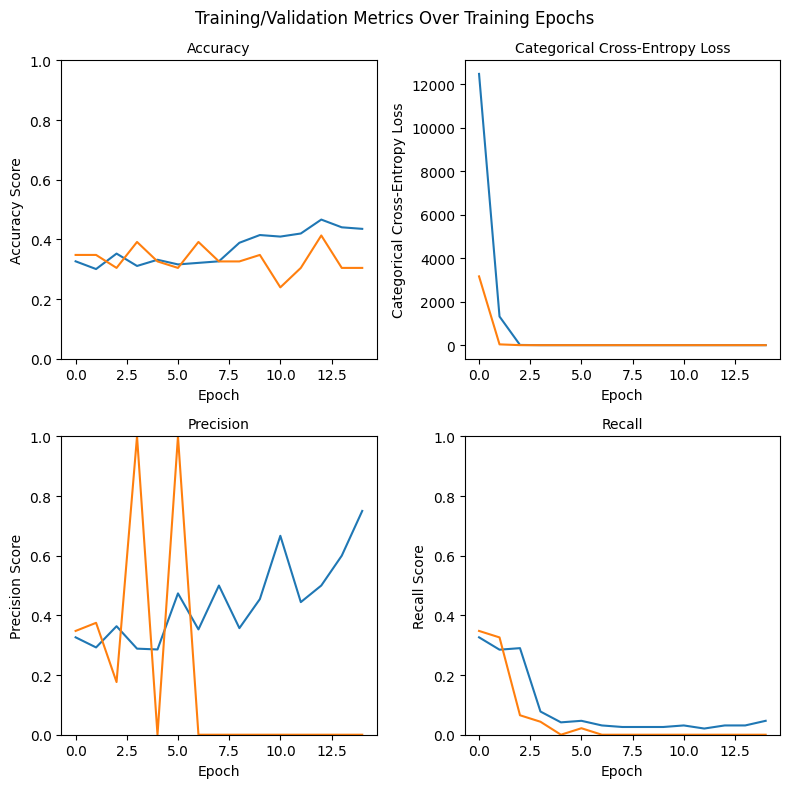

In [22]:
plot_history(pd.DataFrame(history.history))

There was a slight improvement in accuracy but performance was generally at all metrics, essentially randomly guessing.

In [11]:
# Predicting on test data - no image augmentation

test_datagen = keras.preprocessing.image.ImageDataGenerator()

testing_set = train_datagen.flow_from_directory("input/test_data", target_size=(400,400), class_mode="categorical")

Found 103 images belonging to 3 classes.


In [12]:
model_results = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

In [13]:
def evaluate_model(res, model_name):
    return {"Model": model_name, "Loss": res[0], "Accuracy": res[1], 
            "Precision": res[2], "Recall": res[3]}

In [14]:
# Load model if necessary (after crashing)
# model = tf.keras.models.load_model('model/baseline_model.keras')

In [15]:
model_results.loc[len(model_results.index)] = evaluate_model(model.evaluate(testing_set), "baseline_model")

model_results.head()
                     

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.3658 - loss: 1.1090 - precision: 0.3867 - recall: 0.0244


,Model,Loss,Accuracy,Precision,Recall
0,baseline_model,1.106902,0.349515,0.019417,0.4


In [27]:
model.save("model/baseline_model.keras")

### Model Improvements

I believe an average pooling during initial layers is more useful in this case - it can pick up better on the colour differences compared to max.

I also believe a double dense layer might be useful in getting main attributes.

We might be able to vary some parameters - **convolution window, activation function, batch_size, epochs**

We're going to start with a basic function to making training easier.

#### Varying convolution kernel window

In [29]:
ws_results = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

# Varying window_size
for window_size in range(3, 12, 2):
    model = Sequential([
        Conv2D(32, (window_size, window_size), activation='relu', input_shape=training_set.image_shape),
        AveragePooling2D((2, 2)),
        Conv2D(64, (window_size, window_size), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(150, activation='relu'),
        Dense(20, activation='relu'), # Double Dense Layer
        Dense(3, activation='softmax')
    ])

    # Compiling/Fitting Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

    # Fit the model with class weights 
    # 10 epochs
    history = model.fit(training_set, epochs=10, batch_size=1000, validation_data=validation_set, verbose=0)

    ws_results.loc[len(ws_results.index)] = evaluate_model(model.evaluate(testing_set), f"{window_size}_ws_model")

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 575ms/step - accuracy: 0.3359 - loss: 1.0895 - precision: 0.8000 - recall: 0.0244


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - accuracy: 0.3383 - loss: 1.0982 - precision: 0.0000e+00 - recall: 0.0000e+00


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - accuracy: 0.3237 - loss: 1.1005 - precision: 0.0000e+00 - recall: 0.0000e+00


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 886ms/step - accuracy: 0.3492 - loss: 1.0939 - precision: 0.7000 - recall: 0.0153


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 964ms/step - accuracy: 0.3185 - loss: 1.1004 - precision: 0.0000e+00 - recall: 0.0000e+00


In [30]:
ws_results.head()

,Model,Loss,Accuracy,Precision,Recall
0,3_ws_model,1.092128,0.339806,0.019417,0.666667
1,5_ws_model,1.099138,0.330097,0.000000,0.000000
2,7_ws_model,1.100182,0.330097,0.000000,0.000000
3,9_ws_model,1.097935,0.349515,0.009709,0.500000
4,11_ws_model,1.099608,0.330097,0.000000,0.000000


All models perform at the same level - very poorly.

#### Varying activation function

In [32]:
af_results = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

# Varying window_size
for activation_function in ['relu', 'sigmoid', 'tanh']:
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation_function, input_shape=training_set.image_shape),
        AveragePooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(150, activation=activation_function),
        Dense(20, activation=activation_function), # Double Dense Layer
        Dense(3, activation='softmax')
    ])

    # Compiling/Fitting Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

    # Fit the model with class weights 
    # 10 epochs
    history = model.fit(training_set, epochs=10, batch_size=1000, validation_data=validation_set, verbose=0)

    af_results.loc[len(af_results.index)] = evaluate_model(model.evaluate(testing_set), f"{activation_function}_ws_model")



c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.3344 - loss: 1.0903 - precision: 0.6500 - recall: 0.0709


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.3201 - loss: 1.1084 - precision: 0.0000e+00 - recall: 0.0000e+00


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.2920 - loss: 1.1473 - precision: 0.0000e+00 - recall: 0.0000e+00


In [33]:
af_results.head()

,Model,Loss,Accuracy,Precision,Recall
0,relu_ws_model,1.096610,0.320388,0.067961,0.583333
1,sigmoid_ws_model,1.108144,0.310680,0.000000,0.000000
2,tanh_ws_model,1.134744,0.310680,0.000000,0.000000


All models perform at the same level regardless of the activation function - very poorly.

#### Varying Batch Size

In [16]:
bs_results = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

# Varying window_size
for bs in [100, 400, 800, 1600]:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape = training_set.image_shape),
        AveragePooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(150, activation='relu'),
        Dense(20, activation='relu'), # Double Dense Layer
        Dense(3, activation='softmax')
    ])

    # Compiling/Fitting Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

    # Fit the model with class weights 
    # 10 epochs
    history = model.fit(training_set, epochs=10, batch_size=bs, validation_data=validation_set, verbose=0)

    bs_results.loc[len(bs_results.index)] = evaluate_model(model.evaluate(testing_set), f"{bs}_ws_model")



c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - accuracy: 0.3513 - loss: 1.2668 - precision: 0.4491 - recall: 0.1045


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.3541 - loss: 1.0872 - precision: 0.6200 - recall: 0.0395


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - accuracy: 0.3154 - loss: 1.1323 - precision: 0.0000e+00 - recall: 0.0000e+00


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.3185 - loss: 1.1110 - precision: 0.5927 - recall: 0.0738


In [17]:
bs_results.head()

,Model,Loss,Accuracy,Precision,Recall
0,100_ws_model,1.239944,0.349515,0.097087,0.434783
1,400_ws_model,1.082720,0.359223,0.038835,0.666667
2,800_ws_model,1.135162,0.330097,0.000000,0.000000
3,1600_ws_model,1.134255,0.330097,0.077670,0.470588


All models perform at the same level regardless of the batch size - very poorly.

Varying Epochs

In [18]:
epoch_results = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall"])

# Varying window_size
for epoch in [10, 20, 30]:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape = training_set.image_shape),
        AveragePooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(150, activation='relu'),
        Dense(20, activation='relu'), # Double Dense Layer
        Dense(3, activation='softmax')
    ])

    # Compiling/Fitting Model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

    # Fit the model with class weights 
    # 10 epochs
    history = model.fit(training_set, epochs=epoch, batch_size=1000, validation_data=validation_set, verbose=0)

    epoch_results.loc[len(epoch_results.index)] = evaluate_model(model.evaluate(testing_set), f"{epoch}_ws_model")

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - accuracy: 0.3076 - loss: 1.1262 - precision: 0.0000e+00 - recall: 0.0000e+00


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - accuracy: 0.3411 - loss: 1.1262 - precision: 1.0000 - recall: 0.0153


c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - accuracy: 0.3268 - loss: 1.2475 - precision: 0.3590 - recall: 0.0836


In [19]:
epoch_results.head()

,Model,Loss,Accuracy,Precision,Recall
0,10_ws_model,1.127578,0.310680,0.000000,0.000000
1,20_ws_model,1.123129,0.339806,0.009709,1.000000
2,30_ws_model,1.230233,0.330097,0.097087,0.416667


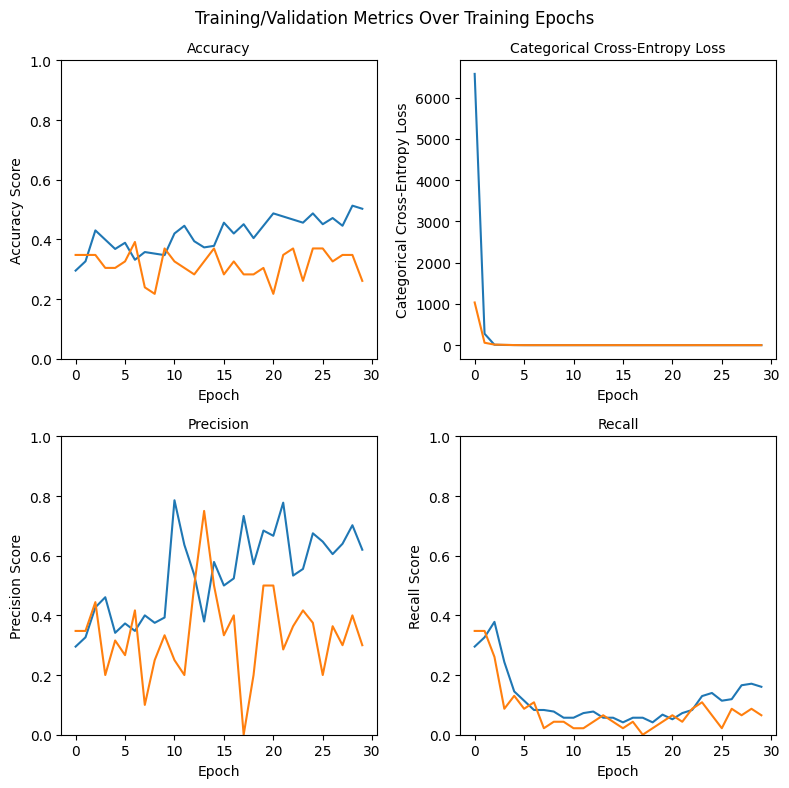

In [21]:
plot_history(pd.DataFrame(history.history))

We can see that there is a slight trend up in accuracy driven from the precision score from the model with 30 epochs - it's learning from the training data but is not able to generalise to unseen data.

This initial model is clearly terrible - it has an accuracy that's close to guessing at random chance (20%). Let's try to improve the complexity of the model.

#### Model 2

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


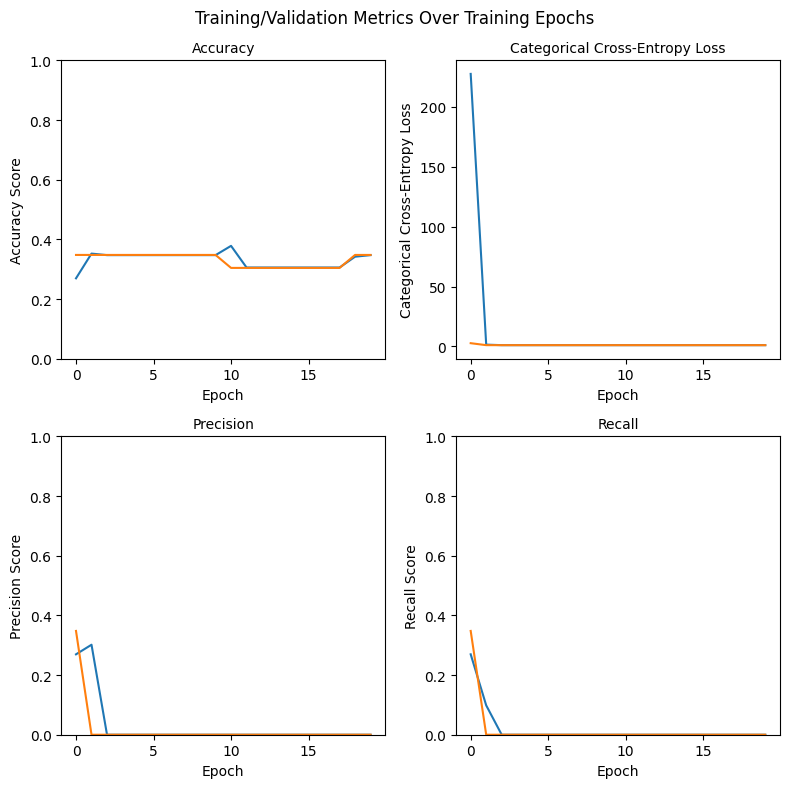

In [22]:
# Increase complexity of model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=training_set.image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dense(20, activation='relu'),
    Dense(3, activation='softmax')
])

# Compiling/Fitting Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Fit the model with class weights
history = model.fit(training_set, epochs=20, batch_size=1000, validation_data=validation_set, verbose=0)

plot_history(pd.DataFrame(history.history))

Our model still lacks the depth required to capture nuances in the model, and does not improve over time. The model flatlines in both precision and accuracy.

In [18]:
# Load model if necessary (after crashing)
# model = tf.keras.models.load_model('model/model_02.keras')

In [23]:
# Add results to dataframe
model_results.loc[len(model_results.index)] = evaluate_model(model.evaluate(testing_set), "model_02")

model_results.sort_values(by="Accuracy", ascending=False)
                     

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 0.2774 - loss: 1.0989 - precision: 0.0000e+00 - recall: 0.0000e+00


,Model,Loss,Accuracy,Precision,Recall
0,baseline_model,1.106902,0.349515,0.019417,0.4
1,model_02,1.098714,0.310680,0.000000,0.0


In [24]:
# Save model
model.save("model/model_02.keras")

Doesn't seem to have much effect - let's change the model architecture.

#### Stacked Model

c:\Users\tobyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


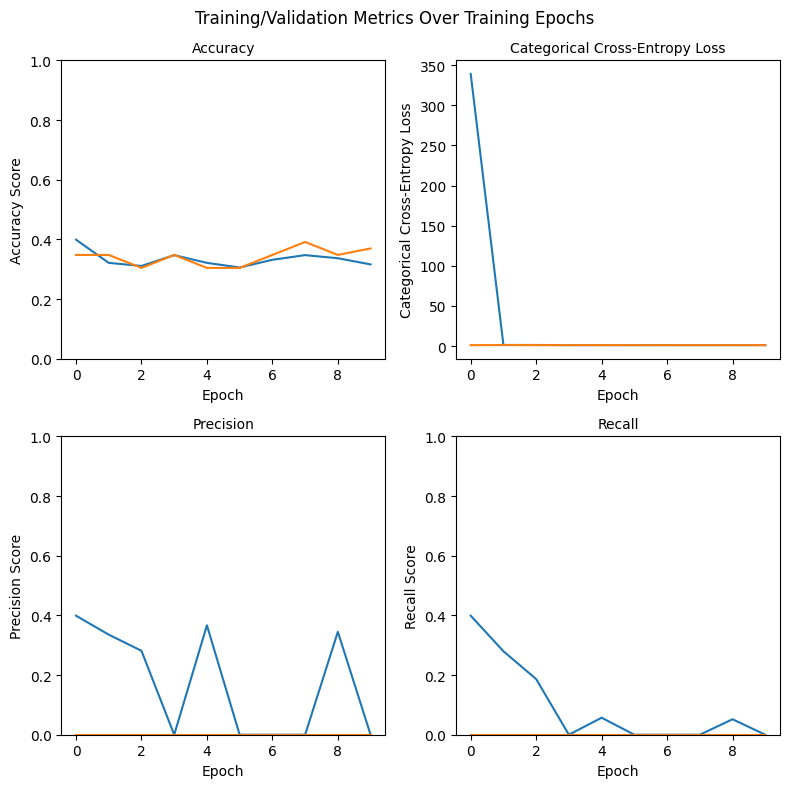

In [25]:
# Stacking convolutional layers together

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=training_set.image_shape),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dense(20, activation='relu'),
    Dense(3, activation='softmax')
])

# Compiling/Fitting Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])

# Fit the model with class weights 
# 10 epochs
history = model.fit(training_set, epochs=10, batch_size=1000, validation_data=validation_set, verbose=0)

plot_history(pd.DataFrame(history.history))

This complex model did not work either - it plateaus almost immediately.

In [ ]:
# Load model if necessary (after crashing)
# model = tf.keras.models.load_model('model/stacked_model_01.keras')

In [27]:
# Add results to dataframe
model_results.loc[len(model_results.index)] = evaluate_model(model.evaluate(testing_set), "stacked_model_01")

model_results.sort_values(by="Accuracy", ascending=False)
                     

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3068 - loss: 1.0998 - precision: 0.0000e+00 - recall: 0.0000e+00


,Model,Loss,Accuracy,Precision,Recall
0,baseline_model,1.106902,0.349515,0.019417,0.4
1,model_02,1.098714,0.310680,0.000000,0.0
2,stacked_model_01,1.099473,0.300971,0.000000,0.0


In [26]:
# Save model
model.save("model/stacked_model_01.keras")

Unfortunately, all the trained models were heavily underfit and unable to pick up the trend, despite best efforts to tweak the possible parameters. It is most likely a mixture of non-ideal model architecture, untuned hyperparameters, and a very difficult task (particularly on my local machine). 


There are some takeaways/findings from the experience:
1. **None of the parameters does not seem to matter.** The models seem to pick up on red herrings/other patterns and are unable to capture the nuance behind gerrymandering, despite introducing more complexity into the model (as much as my local machine can take - cloud computing would help in this regard.)
2. Training on nuanced trends within maps may be **incredibly difficult for a CNN** - it may require more complex types of convolution models to pick up necessary 
3. My **sample size is too small, despite image augmentation.** This makes it easy to overfit across the small sample size (my models did not get to this stage regularly - I could not fit my model to any trends in the maps). To improve this, we would require either fake maps that have calculated voting (which may differ to real life), or to get maps that go further back in time.